# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.decomposition import PCA

# Read Data

In [2]:
data = pd.read_csv("titanic_cleaned.csv")
print(data.shape)

(825, 1625)


# Train A Model on All the features

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    data.loc[:, data.columns != 'Survived'], data["Survived"], test_size=0.20, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(660, 1624) (165, 1624) (660,) (165,)


In [4]:
clf = MLPClassifier(solver='lbfgs', alpha=0.1,
                                            hidden_layer_sizes=(5,2),
                                            max_iter=90000,activation='tanh',random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

0.8545454545454545
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        98
           1       0.84      0.79      0.82        67

    accuracy                           0.85       165
   macro avg       0.85      0.84      0.85       165
weighted avg       0.85      0.85      0.85       165

0.8445019798964362


# Feature Engineering

### Remove quasi-constant (very small variance) and zero variance

In [5]:
data.drop(data.loc[:, data.var() < 0.01], axis = 1, inplace = True)

### Remove duplicate features

In [6]:
data = data.T.drop_duplicates(keep='first').T

### Remove very strongly correlated features

In [7]:
correlation_matrix = data.corr().abs()
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
data.drop(data[to_drop], axis = 1, inplace = True)

### PCA

#### PCA functions

In [8]:
def featureNormalize(X):
    mu = np.asarray(X).mean(axis=0)
    Y = np.asarray(X - mu)
    sigma = pow(np.var(Y, axis=0), 0.5)
    normalized_X = Y / sigma

    return normalized_X

def pca(X):
    cov = np.cov(X, rowvar=False)
    u, s, _ = np.linalg.svd(cov)
    return u

def projectData(X, U):
    Z = np.dot(np.asmatrix(X), np.asmatrix(U[:, :1]))
    return Z

#### Get strongly correlated pairs

In [9]:
target_column = 'Survived'
corr_matrix = data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
strongly_correlated = []
for column in upper.columns:
    if column == target_column:
        continue
    for i, v in enumerate(upper[column]):
        if upper[column][i] > 0.7 and upper.iloc[i].name != target_column:
            strongly_correlated.append((column, upper.iloc[i].name))
strongly_correlated
#strongly_correlated = [(upper.iloc[i].name,v) for i,v in enumerate(upper.columns) if any(upper[upper.iloc[i].name] > 0.6)]
#print(strongly_correlated)
#upper
#pca = PCA() 
#pca.fit(data)

[('Embarked_S', 'Embarked_C')]

#### Apply PCA on strongly correlated pairs

In [10]:
#TODO: Check for numerical and categorical PCA applied only on numerical
#TODO: iterate PCA until Convergence
for X, Y in strongly_correlated:
    if X not in data.columns or Y not in data.columns:
        continue
    new_name = X + '_' + Y
    pca_input = data[[X,Y]]
    pca_input = featureNormalize(pca_input)
    U = pca(pca_input)
    Z = projectData(pca_input, U)
    Z = pd.DataFrame(Z)
    data.drop([X,Y], axis = 1, inplace = True)
    data[new_name] = Z
data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,"Name_Kelly, Miss. Mary","Name_Laroche, Mr. Joseph Philippe Lemercier",Sex_female,Cabin_D,Embarked_Q,Embarked_S_Embarked_C
0,-1.730108,0.0,3.0,-0.590510,1.0,0.0,-0.626020,0.0,1.0,0.0,1.0,0.0,-0.775765
1,-1.726220,1.0,1.0,0.658215,1.0,0.0,1.524562,0.0,0.0,1.0,0.0,0.0,2.617818
2,-1.722332,1.0,3.0,-0.278329,0.0,0.0,-0.603350,0.0,0.0,1.0,1.0,0.0,-0.775765
3,-1.718444,1.0,1.0,0.424079,1.0,0.0,0.913869,0.0,0.0,1.0,0.0,0.0,-0.775765
4,-1.714556,0.0,3.0,0.424079,0.0,0.0,-0.599151,0.0,1.0,0.0,1.0,0.0,-0.775765


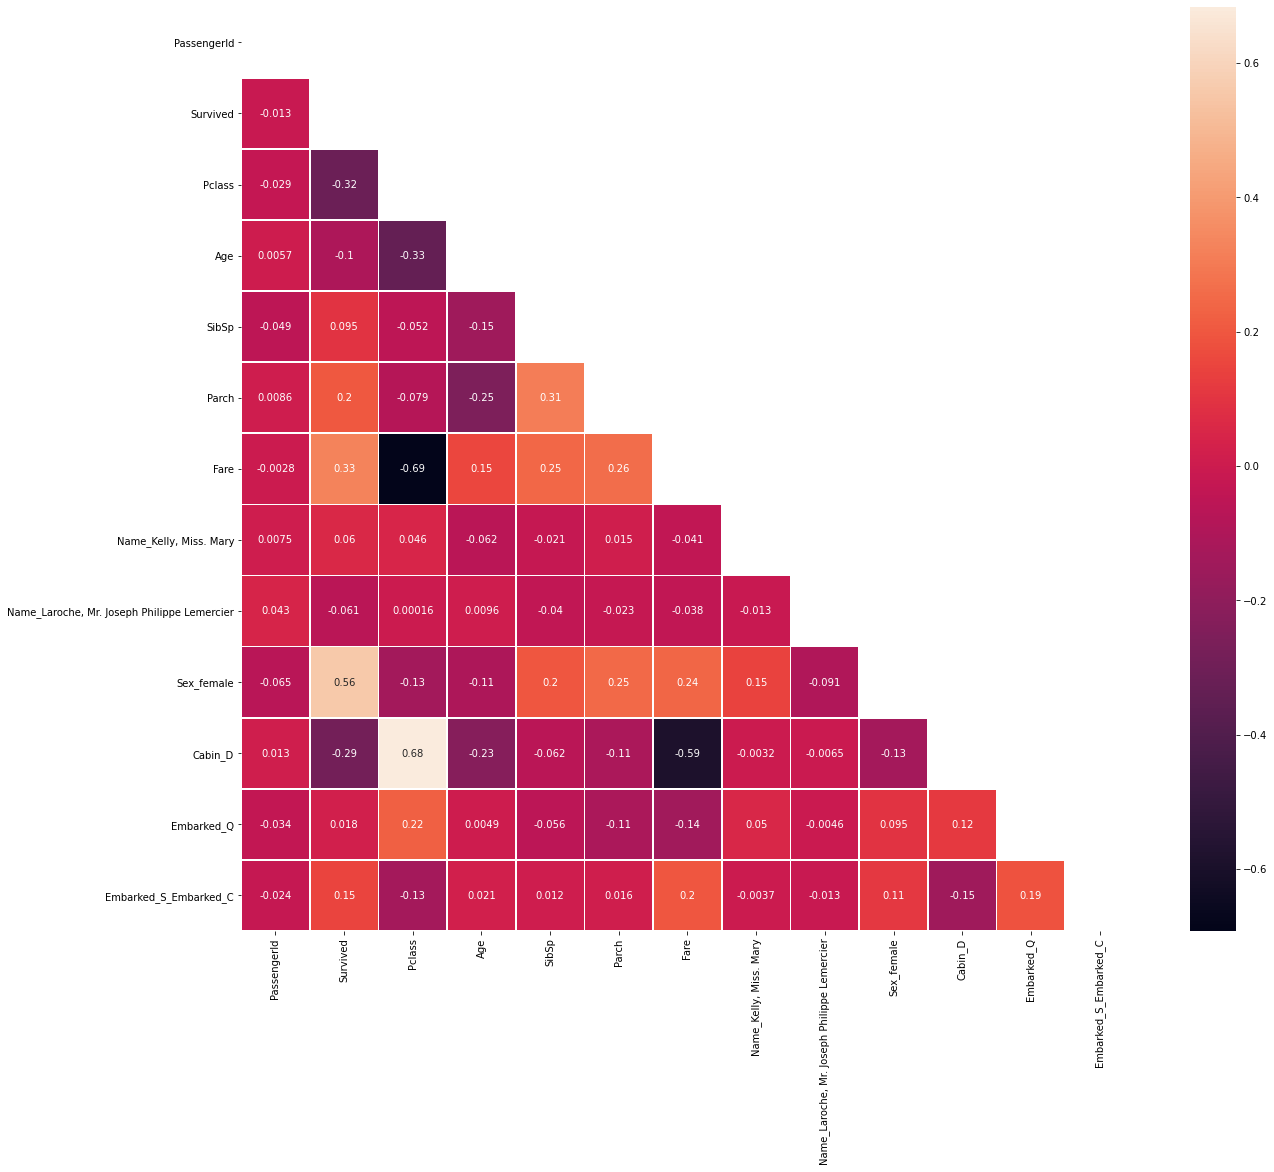

In [11]:
plt.figure(figsize=(20, 17))
matrix = np.triu(data.corr())
sns.heatmap(data.corr(), annot=True,linewidth=.8, mask=matrix, cmap="rocket");

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    data.loc[:, data.columns != 'Survived'], data["Survived"], test_size=0.20, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(660, 12) (165, 12) (660,) (165,)


In [13]:
clf = MLPClassifier(solver='lbfgs', alpha=0.1,
                                            hidden_layer_sizes=(5,2),
                                            max_iter=90000,activation='tanh',random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

0.8
              precision    recall  f1-score   support

         0.0       0.79      0.91      0.84        98
         1.0       0.83      0.64      0.72        67

    accuracy                           0.80       165
   macro avg       0.81      0.77      0.78       165
weighted avg       0.80      0.80      0.79       165

0.7749771550411209
